# **CAPSTONE  PROJECT:  PNEUMONIA  DETECTION**

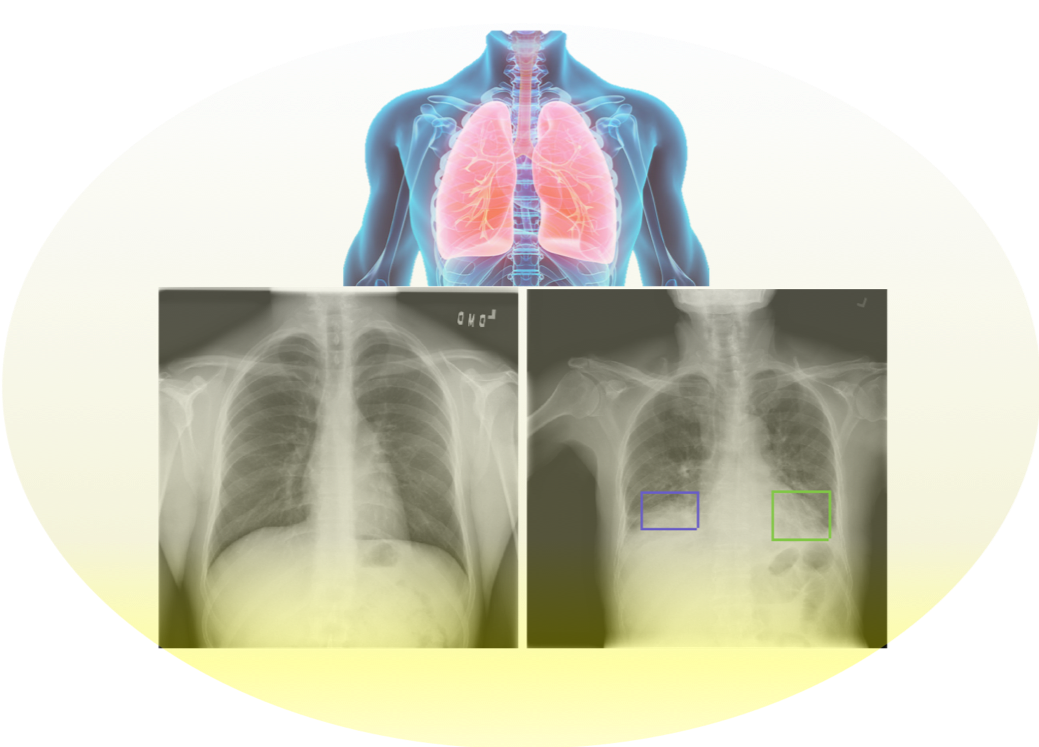


### **PROJECT DESCRIPTION**
In this capstone project, the goal is to build a pneumonia detection system by locating the position(s) of inflammation in patient Chest X-Ray(CXR) images. The project explores a variety of deep neural network architectures to identify optimum detection scheme.

In X-Ray images, tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image, indicating transparency. Dense tissues such as bones absorb X-rays, indicate opacity and appear white in the image. We are detecting “lung opacities” which are indicative of pneumonia. X-ray images in the dataset given are identified as "normal" lungs or annotated by boxes as pneumonia infected "lung opacities" by practicing radiologists. The "lung opacities" typically appear grey and "hazy" in X-ray images with partial transparency and with the lack of a clear boundary. The additional complexity is that there are also X-ray images where lung opacities are not pneumonia related such as in the case of lung tumors that maybe cancer related or in some cases, chest cavity filled with fluid or even in the case of heart enlargement. In the data, most of these aforementioned cases are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. The X-ray medical images are stored in DICOM format files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.



Details about the data and the dataset files are extracted from the link, 

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

### **INITIATION - REQUIRED LIBRARIES AND DRIVE MOUNT**

In [10]:
# Installing pydicom to read dcm files
!pip install -q pydicom

     |████████████████████████████████| 35.5MB 84kB/s 


In [37]:
# Import necessary packages/Library
import pydicom as dcm
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, zipfile, random, csv
import seaborn as sns
#
from matplotlib.pyplot import show
from matplotlib.patches import Rectangle
from tqdm import tqdm_notebook
from pydicom import dcmread
from pydicom.data import get_testdata_file
import os
import glob
#
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# Set path to G-Drive
from google.colab import drive
drive.mount('/content/drive')
print(os. getcwd())
print(os.listdir())
os.chdir('/content/drive/My Drive/Colab Notebooks/Capstone')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content
['.config', 'drive', 'sample_data']


### **DOWNLOAD DATASET**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mbalasu","key":"40b8ae7f675ecb3c9e9a19913af65fc8"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
'chmod 600 /root/.kaggle/kaggle.json'

'chmod 600 /root/.kaggle/kaggle.json'

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c rsna-pneumonia-detection-challenge

Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
100% 3.66G/3.66G [01:12<00:00, 28.8MB/s]
100% 3.66G/3.66G [01:12<00:00, 54.1MB/s]


In [6]:
!ls

kaggle.json  rsna-pneumonia-detection-challenge.zip  sample_data


In [12]:
file_name = 'rsna-pneumonia-detection-challenge.zip'
files = zipfile.ZipFile(file_name, 'r')
files.extractall()

In [13]:
!ls

'GCP Credits Request Link - RSNA.txt'	  stage_2_sample_submission.csv
 kaggle.json				  stage_2_test_images
 rsna-pneumonia-detection-challenge.zip   stage_2_train_images
 sample_data				  stage_2_train_labels.csv
 stage_2_detailed_class_info.csv


In [14]:
train_labels = pd.read_csv('stage_2_train_labels.csv')
class_info = pd.read_csv('stage_2_detailed_class_info.csv')

### **EXPLORATIVE DATA ANALYSIS**



1.  Images for testing and training are in the folders: stage_2_train_images and stage_2_test_images.
2.  Training data 1: "stage_2_train_labels.csv" containing the box annotation coordinates and the targets (1-pneumonia and 0-not pneumonia)
3.  Training data 2: "stage_2_detailed_class_info.csv" containing detailed information about the classes in the training set ("normal", "lung opacities" and "No lung opacity/not normal" classes)



**DATASET SUMMARY**

In [17]:
print(f'Train Labels dataframe has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')#(0 for rows and 1 for columns)
print(f'Class info dataframe has {class_info.shape[0]} rows and {class_info.shape[1]} columns')

Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns


In [18]:
print('No. of Unique patient IDs in train_labels:', train_labels['patientId'].nunique() )
print('No. of Unique patient IDs in class_info:', class_info['patientId'].nunique() )

No. of Unique patient IDs in train_labels: 26684
No. of Unique patient IDs in class_info: 26684


In [19]:
#
# Dataframe basic data study with report
#
def df_data_study(df):
#
# basic data info
    print("\033[1m"+'\nSHAPE\n'+"\033[0m")
    print(df.shape)
    print("\033[1m"+'\nHEAD(5)\n'+"\033[0m")
    print(df.head())
    print("\033[1m"+'\nINFO\n'+"\033[0m")
    print(df.info())
    print("\033[1m"+'\nNUMERIC DATA DESCRIPTION\n'+"\033[0m")
    print(df.describe())
#
# null count and %age
    df_null=df.isnull().sum()
    df_count=df.isnull().count()
    null_percent=df_null*100/df_count
    print("\033[1m"+'\nNULL DATA TABLE\n'+"\033[1m")
    return pd.concat([df_null, round(null_percent,1)], axis=1, keys=['Null Count', 'Null_percent'])
#

In [20]:
print("\033[1m" + 'TRAIN LABELS DATAFRAME' + "\033[0m")
df_data_study(train_labels)

TRAIN LABELS DATAFRAME

SHAPE

(30227, 6)

HEAD(5)

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usag

,Null Count,Null_percent
patientId,0,0.0
x,20672,68.4
y,20672,68.4
width,20672,68.4
height,20672,68.4
Target,0,0.0


In [23]:
print("\033[1m" + 'CLASS INFO DATAFRAME' + "\033[0m")
df_data_study(class_info)

CLASS INFO DATAFRAME

SHAPE

(30227, 2)

HEAD(5)

                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB
None

NUMERIC DATA DESCRIPTION

                                   patientId                         class
count                                  30227                         30227
unique                             

,Null Count,Null_percent
patientId,0,0.0
class,0,0.0


 
**BASIC DATA SUMMARY**

*   Both dataframes have patient id common identifier and 30227 patient samples obtained from CXR of 26684 unique patients

*   Clearly 6 columns in train_labels dataframe with 4 numeric real data (rectangle of identified pneumonia box each row)
train_labels also has one target class column which is a classifier for patient as pneumonia patient or not (1-yes/0-no)

* 2 columns in the class info dataframe having the 3 classes of data for CXR images(normal, lung opacity and abnormal)for each patient sample

* The training labels data has 68.4% null data for the box identifier of patient CXR which should ideally correspond to number of patients identified with no pneumonia




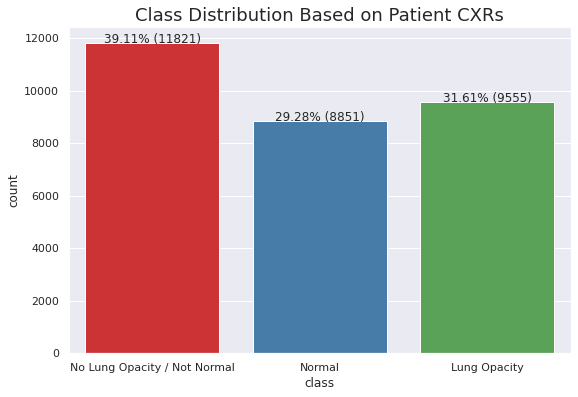

In [26]:
# DATA VISUALIZATION OF PATIENT CLASS DISTRIBUTION BASED ON CXR EVALUATIONS
#
fig,ax= plt.subplots(1,1,figsize=(9,6))
sns.set(style="darkgrid")
plt.title('Class Distribution Based on Patient CXRs', fontsize=18)
sns.countplot(class_info['class'], palette="Set1")
total=float(len(class_info))
for p in ax.patches:
    height=p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}% ({:d})'.format(100*height/total, height),
            ha="center")
#
plt.show()

Lung Opacity class is 31.61% (9555, Target=1) which clearly complements the 68.4% {11821 (39.1%) +8851 (29.3%) =20672 (68.4%), Target=0} null data records in train labels data set

In [ ]:
#
# Let's now merge the dataframes into one with common patientID criteria
#
train_labels=train_labels.merge(class_info,left_on='patientId', right_on='patientId',how='inner')
total_records = train_labels.shape[0]

In [28]:
print(train_labels.shape)
print(total_records)

(37629, 7)
37629


In [29]:
# Drop duplicate records in merged dataframe
train_labels=train_labels.drop_duplicates()
print(train_labels.shape)

(30227, 7)


7402 (=37629-30227) duplicate records have been dropped

In [31]:
# Let's look at the pneumonia patient records only and look at the locations
train_target1=train_labels[train_labels['Target']==1]

<function matplotlib.pyplot.show>

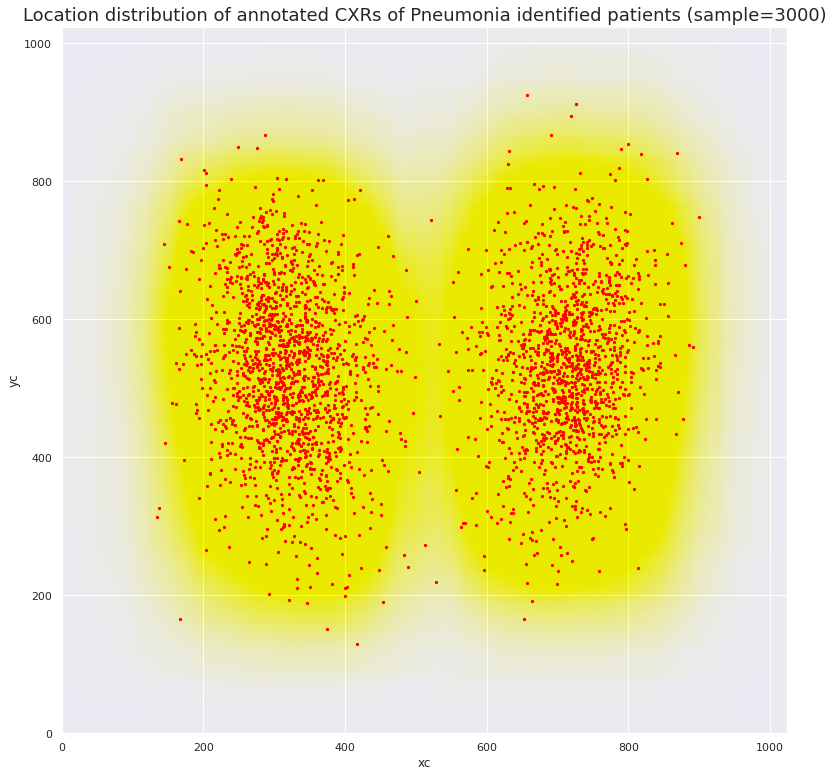

In [32]:
# Let's look at a sampling (3000) of the distribution of the annotated CXRs with centers of rectangles for the dataset
#
fig,ax=plt.subplots(1,1,figsize=(13,13))
train_target2=train_target1.sample(3000)
train_target2['xc']=train_target2['x']+train_target2['width']/2
train_target2['yc']=train_target2['y']+train_target2['height']/2
plt.title('Location distribution of annotated CXRs of Pneumonia identified patients (sample=3000)', fontsize=18)
train_target2.plot.scatter(x='xc',y='yc', xlim=(0,1024),ylim=(0,1024), ax=ax, marker='.',c="red")
for i,annot in train_target2.iterrows():
    ax.add_patch(Rectangle(xy=(annot['x'],annot['y']),width=annot['width'],height=annot['height'],alpha=0.004, color="yellow"))
plt.show

### Clearly rectangular annotations are concentrated between x=250to400 & x=650to800(symmetric) and y=400to700

In [34]:
# Eliminate the 3rd class of "Not normal/No Lung capacity" by replacing the string with normal
train_labels1=train_labels.replace("No Lung Opacity / Not Normal","Normal")

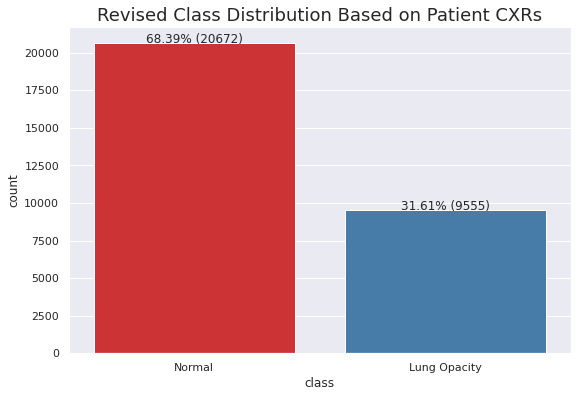

In [36]:
# DATA VISUALIZATION OF PATIENT CLASS DISTRIBUTION BASED ON CXR EVALUATIONS
#
fig,ax= plt.subplots(1,1,figsize=(9,6))
sns.set(style="darkgrid")
plt.title('Revised Class Distribution Based on Patient CXRs', fontsize=18)
sns.countplot(train_labels1['class'], palette="Set1")
total=float(len(class_info))
for p in ax.patches:
    height=p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}% ({:d})'.format(100*height/total, height),
            ha="center")
#
plt.show()

In [39]:
# Let's tabulate dataset by number of Chest X Ray (CXR) count and classification (class) per patient
#
CXRs=train_labels1.groupby(['patientId','Target','class'])['patientId'].count()
df1=pd.DataFrame(data={'CXRs_count':CXRs.values},index=CXRs.index).reset_index()
#Class_g=CXRs.groupby(['patientId','Target','class'])['class']
#Target_g=train_labels.groupby(['patientId','Target','class'])['Target']
new_df=df1.drop(['patientId'],axis=1)
new_df1=new_df.groupby(['Target','class','CXRs_count'])['CXRs_count'].count()
print(new_df1)

Target  class         CXRs_count
0       Normal        1             20672
1       Lung Opacity  1              2614
                      2              3266
                      3               119
                      4                13
Name: CXRs_count, dtype: int64


### **EXPLORE DICOM-IMAGE DATASET**

### Load Image Data

In [38]:
# Load Image Dataset from Train and Test folder
imgArr_train=list(set(glob.glob('stage_2_train_images/'+'*.dcm')))
imgArr_test=list(set(glob.glob('stage_2_test_images/'+'*.dcm')))
print("Number of train set images:",len(imgArr_train))
print("Number of test set images:",len(imgArr_test))

Number of train set images: 26684
Number of test set images: 3000


In [40]:
# Let's pick a Ramdom Sample to look at DICOM image and meta data structure

dicom_data=dcm.read_file(imgArr_train[23])
dicom_data

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.21578.1517874434.982155
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.21578.1517874434.982155
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

### The Key Data to extract includes
1.   Pixel Data: for images
2.   Patient's ID
3.   Patient's Sex
4.   Patient's Age
5.   Modality




### Let's Display a few sample CXR images with box data annotations

In [54]:
def disp_dicom_img(data):
    img_data=list(data.T.to_dict().values())
    fig,ax=plt.subplots(3,5,figsize=(27,18))
    for i,row in enumerate(img_data):
        image_fname=row['patientId']+'.dcm'
        image_fpath=os.path.join("stage_2_train_images/",image_fname)
        row_img_data=dcm.read_file(image_fpath)
        modality=row_img_data.Modality
        age=row_img_data.PatientAge
        sex=row_img_data.PatientSex
        data_row_img=dcm.dcmread(image_fpath)
        ax[i//5,i%5].imshow(data_row_img.pixel_array,cmap=plt.cm.bone)
        ax[i//5,i%5].axis('off')
        ax[i//5,i%5].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass:  {}'.format(row['patientId'],modality,age,sex,row['Target'],row['class']))
        rows1=train_labels1[train_labels1['patientId']==row['patientId']]
        box=list(rows1.T.to_dict().values())
        for j,row2 in enumerate(box):
          ax[i//5,i%5].add_patch(Rectangle(xy=(row2['x'],row2['y']),width=row2['width'],height=row2['height'],alpha=0.3,color="blue",))
    plt.show()

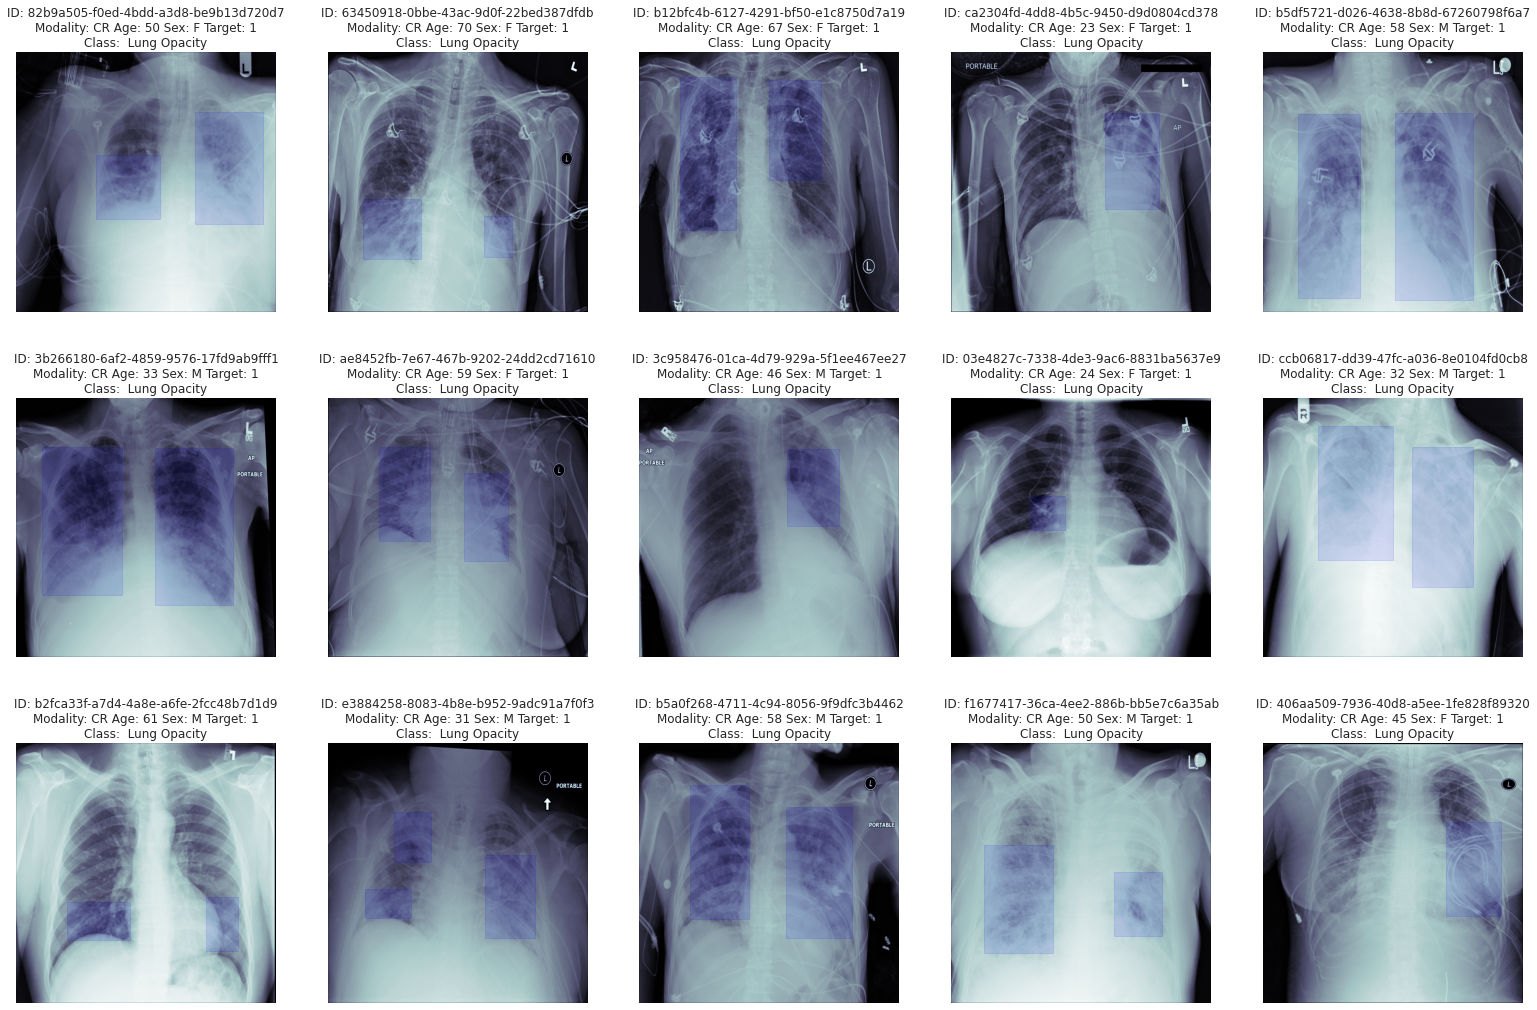

In [53]:
disp_dicom_img(train_labels1[train_labels1['Target']==1].sample(15))